In [261]:
import pandas as pd
import numpy as np
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer, WhitespaceTokenizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import matplotlib.pyplot as plt
import seaborn as sns

import re

In [262]:
df_selftext = pd.read_csv('../data/selftext.csv')
df_notext = pd.read_csv('../data/notext.csv')
df_posts = pd.read_csv('../data/posts.csv')

dflist = [df_selftext,df_notext,df_posts]

In [263]:
df_notext.shape

(11999, 13)

In [264]:
df_selftext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4944 entries, 0 to 4943
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   subreddit      4944 non-null   object 
 1   selftext       4814 non-null   object 
 2   title          4933 non-null   object 
 3   upvote_ratio   4944 non-null   float64
 4   score          4944 non-null   int64  
 5   id             4944 non-null   object 
 6   author         4944 non-null   object 
 7   num_comments   4944 non-null   int64  
 8   created_utc    4944 non-null   object 
 9   retrieved_utc  4944 non-null   int64  
 10  updated_utc    4944 non-null   int64  
 11  post_date      4944 non-null   object 
 12  post_time      4944 non-null   object 
dtypes: float64(1), int64(4), object(8)
memory usage: 502.2+ KB


# target

In [265]:
df_selftext.subreddit.value_counts()

bitcoin     4146
ethereum     798
Name: subreddit, dtype: int64

In [266]:
def targetize(df):
    df['subreddit'] = df.subreddit.apply(lambda x: 0 if x == 'bitcoin' else 1)
    return df

df_selftext,df_notext,df_posts = [targetize(i) for i in dflist]

In [267]:
df_selftext.shape

(4944, 13)

In [268]:
# a few nans from import blanks
df_selftext.isna().sum()

subreddit          0
selftext         130
title             11
upvote_ratio       0
score              0
id                 0
author             0
num_comments       0
created_utc        0
retrieved_utc      0
updated_utc        0
post_date          0
post_time          0
dtype: int64

# Drop additional cols for now, would like to explore metadata (scoring, authorship. Comment mapping with extra time)

In [269]:
df_selftext['text'] = df_selftext['title'] +' ' + df_selftext['selftext']
df_notext['text'] = df_notext['title']

In [270]:
targetcols = ['subreddit', 'text']

In [271]:
for i in [df_selftext, df_notext]:
    i.drop(columns=[i for i in i.columns if i not in targetcols], inplace = True)

In [272]:
df_notext.head()

,subreddit,text
0,0,bitcoin oreo
1,0,til hacker employee following directions from ceo
2,0,does tracking the capacity of top lightning no...
3,0,little known surillance program captures money...
4,0,using electric water boilers to mine bitcoin


In [273]:
df_notext.isna().sum()

subreddit    0
text         2
dtype: int64

In [274]:
df_selftext.isna().sum()

subreddit      0
text         140
dtype: int64

In [275]:
for i in dflist:
    i.dropna(inplace = True)

# Split to target DFs

In [276]:
def split_df_to_target(df):
    btc = df[df['subreddit'] == 0]
    eth = df[df['subreddit'] == 1]
    
    btc.reset_index
    eth.reset_index
    
    return btc, eth

In [277]:
btc_notext, eth_notext = split_df_to_target(df_notext)
btc_selftext, eth_selftext = split_df_to_target(df_selftext)

# Pre lemmatization eda

In [278]:
# adding stop words, moving some of them to earlier cleaning 
stop = list(stopwords.words('english'))
stop.extend('btc eth bitcoin ethereum lightning vitalik know use think removed view poll free ha'.split())

In [279]:
def ngram_maker(df, transformer, stop_words, count, ngram_start, n_gram_stop):
    
    #df is df, transformer is what you'd call your transformer, the rest is the rest. Count is int at end
    
    if transformer == 'cvec':
        trans = CountVectorizer(stop_words = stop_words, ngram_range = (ngram_start,n_gram_stop))
    else:
        trans = TfidfVectorizer(stop_words = stop_words, ngram_range = (ngram_start,n_gram_stop))
    
    
    vectorized = trans.fit_transform(df['text'])
    df_vec = pd.DataFrame(vectorized.todense(), columns = trans.get_feature_names_out())
    df_vec.sum().T.sort_values(ascending = True).tail(count).plot.barh();

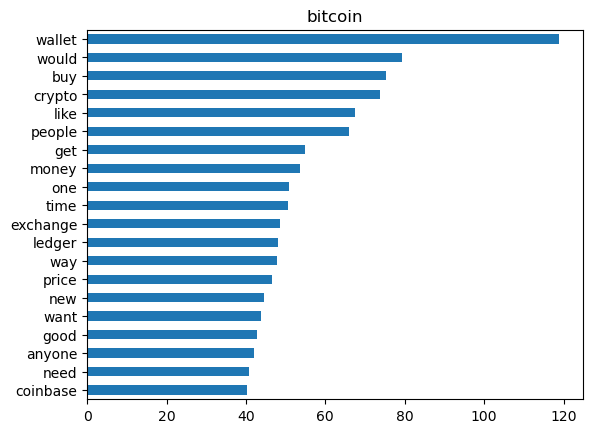

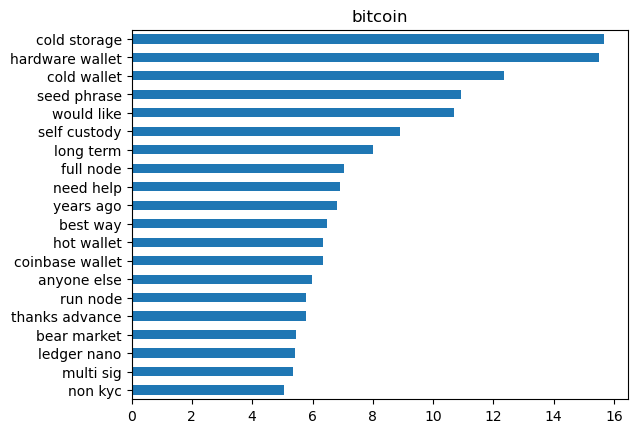

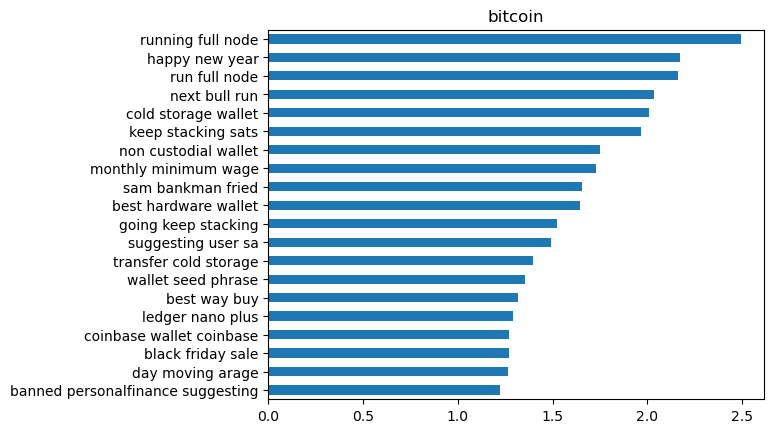

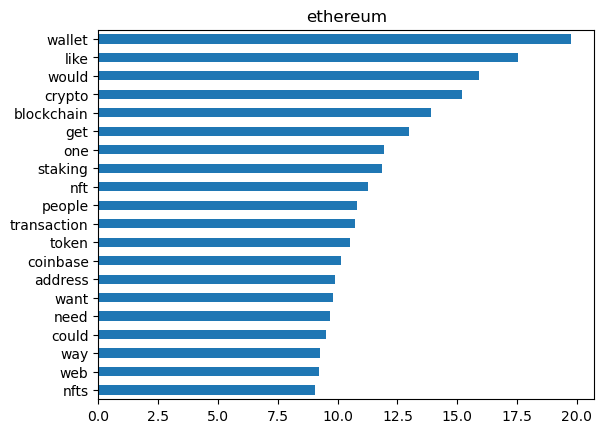

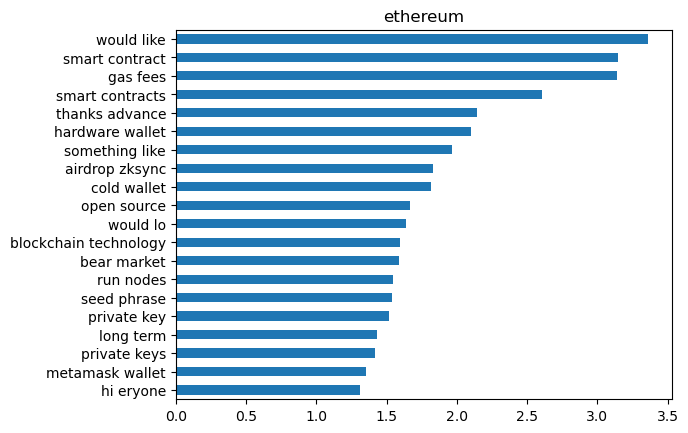

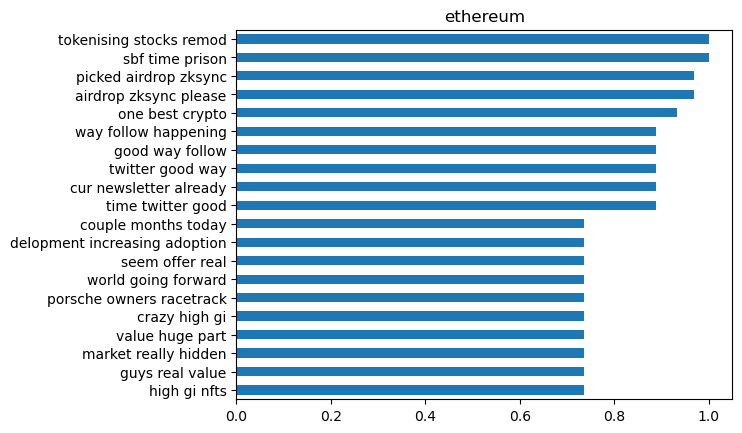

In [280]:
dfs = [btc_selftext, eth_selftext]
startrange = [1,2,3]
#transformers = [cvec, tvec]

counter = 1
for i in dfs:
    for k in startrange:
        plt.figure()
        if counter > 3:
            plt.title('ethereum')
        else:
            plt.title('bitcoin')

        ngram_maker(i, 'tvec', stop, 20, k, k)
        counter+=1
    else:
        pass

# Eda, cleanup via tokenization / lemmatization

In [281]:
#https://stackoverflow.com/questions/61987040/how-to-lemmatise-a-dataframe-column-python
# https://stackoverflow.com/questions/47557563/lemmatization-of-all-pandas-cells

# could get very into lemmatization alone as all this is quite frustrating: https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word
# as an aside, spoke with patrick burns about the http://cltk.org/ project, as i  was scraping and parsing catullus manually until i found cltk via lemmatization.
# he specificically is working on this library for latin to tag part of speech with training to improve lemmatization https://github.com/diyclassics/la_dep_cltk_sm

tokenizer = WhitespaceTokenizer()
lemmatizer = WordNetLemmatizer()

In [282]:
print(df_notext.subreddit.value_counts(normalize = True))
df_selftext.subreddit.value_counts(normalize = True)

0    0.828374
1    0.171626
Name: subreddit, dtype: float64


0    0.836178
1    0.163822
Name: subreddit, dtype: float64

In [283]:
def lemmatize_func(text):
        return ' '.join([lemmatizer.lemmatize(i) for i in tokenizer.tokenize(text)])

df_notext['text'] = df_notext.text.apply(lemmatize_func)
df_selftext['text'] = df_selftext.text.apply(lemmatize_func)


In [284]:
df_selftext.subreddit.value_counts()

0    4017
1     787
Name: subreddit, dtype: int64

# EDA lemmatized

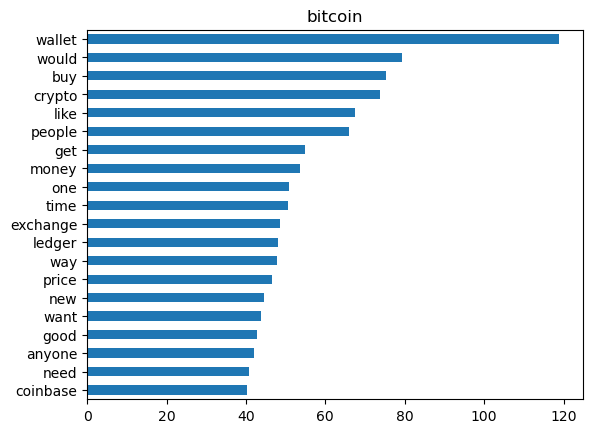

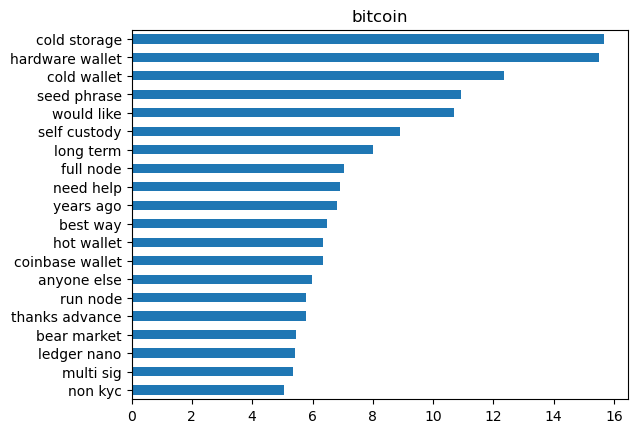

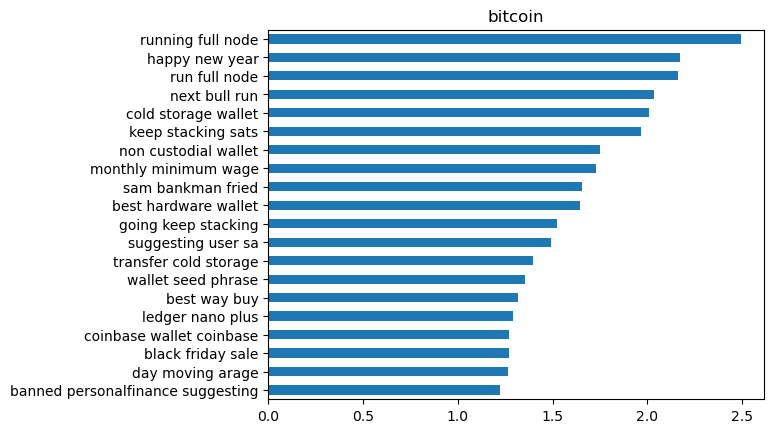

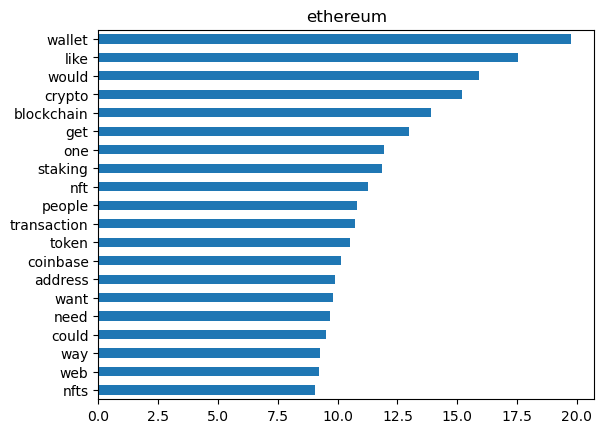

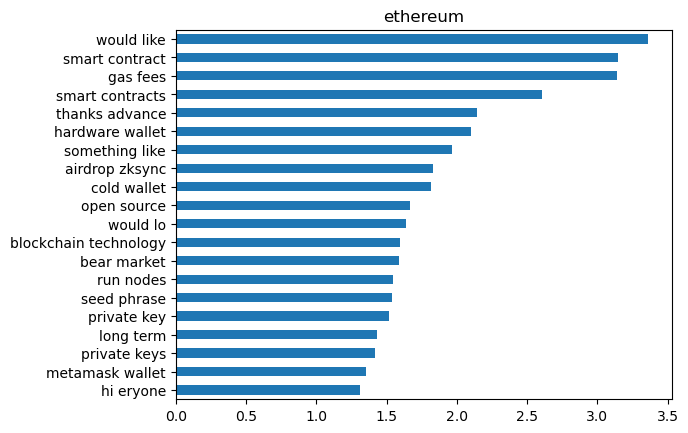

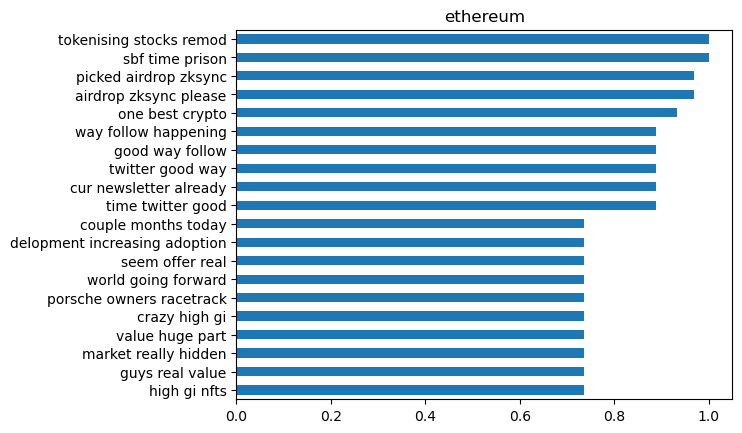

In [285]:
dfs = [btc_selftext, eth_selftext]
startrange = [1,2,3]
#transformers = [cvec, tvec]

counter = 1
for i in dfs:
    for k in startrange:
        plt.figure()
        if counter > 3:
            plt.title('ethereum')
        else:
            plt.title('bitcoin')
 
        ngram_maker(i, 'tvec', stop, 20, k, k)
        counter+=1
    else:
        pass

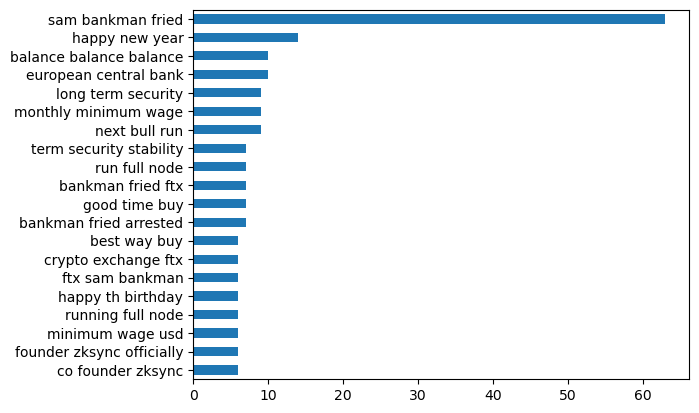

In [286]:
# checking out cvec for comparison

cvec = CountVectorizer(stop_words = stop, ngram_range = (3,3))
btc_text = cvec.fit_transform(btc_notext['text'])
btc_selftext_corp = pd.DataFrame(btc_text.todense(), columns = cvec.get_feature_names_out())
btc_selftext_corp.sum().T.sort_values(ascending = True).tail(20).plot.barh();

# Sentiment analysis

In [287]:
sent = SentimentIntensityAnalyzer()

In [288]:
sent.polarity_scores('fungible token increasing')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [289]:
btc_selftext.shape

(4017, 2)

In [290]:
btc_selftext.reset_index
eth_selftext.reset_index
print(eth_selftext.index)

Int64Index([4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155,
            ...
            4933, 4934, 4935, 4936, 4937, 4938, 4940, 4941, 4942, 4943],
           dtype='int64', length=787)


In [291]:
def polarity_score(series, df):
    print(df.index)
    array = [] # array of dicts actually
    for row in series:
            #print(row)
        array.append(sent.polarity_scores(row))
    print(df.shape)
    my_map = {"neg": "neg", "neu": "neu", "pos": "pos", 'compound':'compound'}
    newdf = pd.DataFrame.from_records(array)

    #align indexes
    newdf.index = pd.RangeIndex(len(newdf.index))
    df.index = pd.RangeIndex(len(df.index))

    
    finaldf = df.join(newdf)

    return finaldf
    #newdf = df.join(newdf)
    

            
btc_selftext = polarity_score(btc_selftext['text'],btc_selftext)
eth_selftext = polarity_score(eth_selftext['text'],eth_selftext)

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            4135, 4136, 4137, 4138, 4140, 4141, 4142, 4143, 4144, 4145],
           dtype='int64', length=4017)
(4017, 2)
Int64Index([4146, 4147, 4148, 4149, 4150, 4151, 4152, 4153, 4154, 4155,
            ...
            4933, 4934, 4935, 4936, 4937, 4938, 4940, 4941, 4942, 4943],
           dtype='int64', length=787)
(787, 2)


In [292]:
eth_selftext

,subreddit,text,neg,neu,pos,compound
0,1,how to stake eth without selling i want to st...,0.040,0.903,0.057,0.2514
1,1,cannot enter into ethereum's discord trying to...,0.217,0.783,0.000,-0.6757
2,1,top zkevm projects the key to ethereum s scala...,0.031,0.946,0.023,-0.1531
3,1,ethereum network validators ha surged to as sh...,0.042,0.823,0.135,0.9657
4,1,blockchain tech is here to stay and is shaping...,0.011,0.834,0.155,0.9924
...,...,...,...,...,...,...
782,1,how to generate your wallet friends we are gl...,0.000,0.848,0.152,0.7269
783,1,instagram is launching nft's on polygon this i...,0.000,0.742,0.258,0.9808
784,1,betplay fastest crypto casino with eth is one ...,0.000,0.640,0.360,0.9509
785,1,essay reducing the barrier for crypto using me...,0.149,0.780,0.071,-0.9319


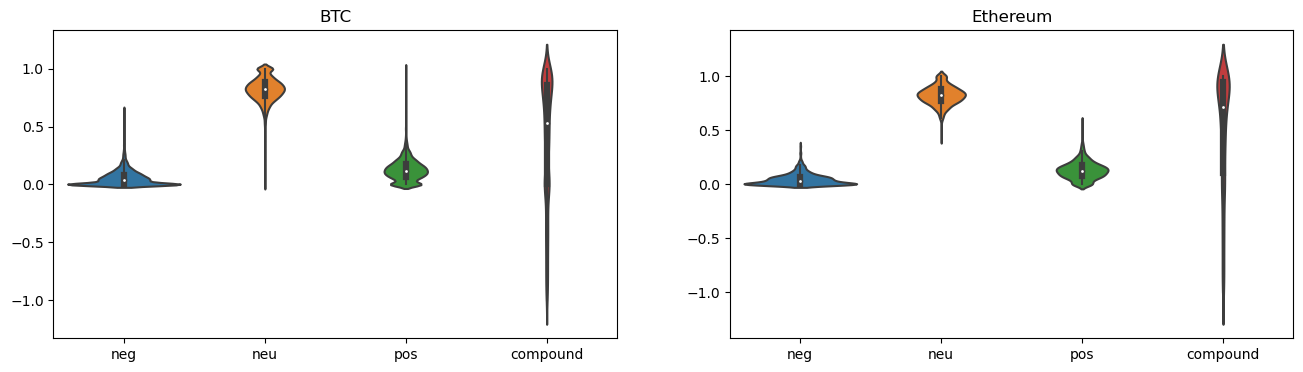

In [293]:
variables=['neg', 'neu','pos','compound']

fig, axes = plt.subplots(1, 2, figsize=(16,4))

sns.violinplot(data=btc_selftext[variables], ax=axes[0]);
axes[0].set_title('BTC')
sns.violinplot(data=eth_selftext[variables], ax=axes[1]);
axes[1].set_title('Ethereum');

In [294]:
for i in variables:
    print(f'bitcoin metrics \n {i} mean: {btc_selftext[i].mean()}, \n {i}  median: {btc_selftext[i].std()}')
    print(f'eth metrics \n {i} mean: {eth_selftext[i].mean()}, \n {i}  median: {eth_selftext[i].std()}')

bitcoin metrics 
 neg mean: 0.05449663928304716, 
 neg  median: 0.06587272718213552
eth metrics 
 neg mean: 0.04702922490470139, 
 neg  median: 0.05405717837744838
bitcoin metrics 
 neu mean: 0.8200873786407785, 
 neu  median: 0.1038101027491693
eth metrics 
 neu mean: 0.822975857687421, 
 neu  median: 0.08653244064564272
bitcoin metrics 
 pos mean: 0.12540876275827723, 
 pos  median: 0.09166099362258857
eth metrics 
 pos mean: 0.13000889453621348, 
 pos  median: 0.08017332478636875
bitcoin metrics 
 compound mean: 0.3723876524769715, 
 compound  median: 0.5537784323745737
eth metrics 
 compound mean: 0.48428843710292263, 
 compound  median: 0.5587656345072884


In [295]:
btc_selftext.head()

,subreddit,text,neg,neu,pos,compound
0,0,using electric water boilers to mine bitcoin t...,0.013,0.844,0.142,0.9383
1,0,btc to usdt hello i am looking to swap a good ...,0.000,0.869,0.131,0.7964
2,0,hypothetically what if we just treated bitcoin...,0.024,0.844,0.132,0.7717
3,0,how to manage different btcs on one ledger so...,0.034,0.874,0.092,0.5881
4,0,can we discuss dollar cost araging dca as an i...,0.097,0.822,0.081,-0.8400


In [296]:
btc_selftext['text'].str.split()

0       [using, electric, water, boilers, to, mine, bi...
1       [btc, to, usdt, hello, i, am, looking, to, swa...
2       [hypothetically, what, if, we, just, treated, ...
3       [how, to, manage, different, btcs, on, one, le...
4       [can, we, discuss, dollar, cost, araging, dca,...
                              ...                        
4012    [strike, exits, south, dakota, i, asked, strik...
4013    [selling, art, for, btc, hey, bitcoin, folks, ...
4014    [problems, with, a, bitcoin, monetary, standar...
4015    [new, instment, community, looking, for, feedb...
4016    [microstrategy, earnings, what, future, holds,...
Name: text, Length: 4017, dtype: object

# Words in both corpora

In [316]:
def vectorizer(df):
    tvec = TfidfVectorizer(stop_words = stop)
    vectorized = tvec.fit_transform(df['text'])
    df_vec = pd.DataFrame(vectorized.todense(), columns = tvec.get_feature_names_out())
    return df_vec
    
btc_vec = vectorizer(btc_selftext)
eth_vec = vectorizer(eth_selftext)

In [317]:
dual_list = []
for i in btc_vec.columns:
    if i in eth_vec.columns:
        dual_list.append(i)
    else:
        pass

print(len(dual_list))
print(len(btc_vec.columns))
print(len(eth_vec.columns))

5767
15381
8150


In [318]:
%store dual_list

Stored 'dual_list' (list)


In [319]:
#https://stackoverflow.com/questions/3496518/using-a-dictionary-to-count-the-items-in-a-list

# getting top words into dict

def worddict(df):
    
    counts = dict()
    
    for i in df.columns:
        counts[i] = sum(df[i])
    
    counts = dict(sorted(counts.items(), key=lambda x:x[1], reverse = True))

    return counts

btc_words = worddict(btc_vec)
eth_words = worddict(eth_vec)

In [320]:
btc_freq = pd.DataFrame(btc_words.items(), columns=['word', 'btc_freq'])
eth_freq = pd.DataFrame(eth_words.items(), columns=['word', 'eth_freq'])

In [321]:
joined_df = pd.merge(btc_freq, eth_freq)
joined_df = joined_df.set_index('word')

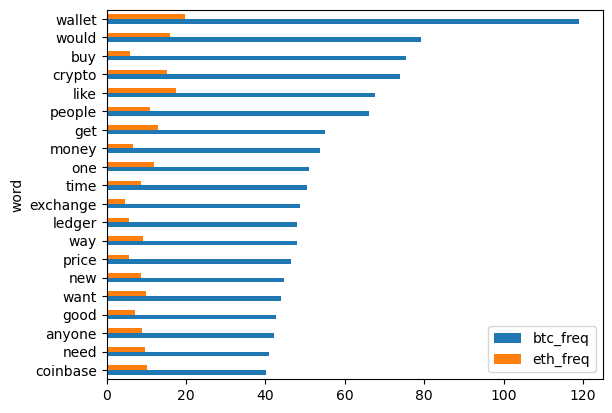

In [322]:
joined_df.sort_values(by = 'btc_freq', ascending = True).tail(20).plot.barh();

In [323]:
# faster than SS https://www.educative.io/answers/how-to-normalize-all-columns-in-a-dataframe-in-pandas

scaled_df = joined_df.apply(lambda iterator: ((iterator.min() - iterator)/(iterator.min() - iterator.max())).round(2))

In [324]:
scaled_df.sort_values(by = 'eth_freq', ascending = False)[:10]

,btc_freq,eth_freq
word,,
wallet,1.00,1.00
like,0.57,0.89
would,0.67,0.81
crypto,0.62,0.77
blockchain,0.20,0.70
get,0.46,0.66
staking,0.04,0.60
one,0.43,0.60
nft,0.04,0.57


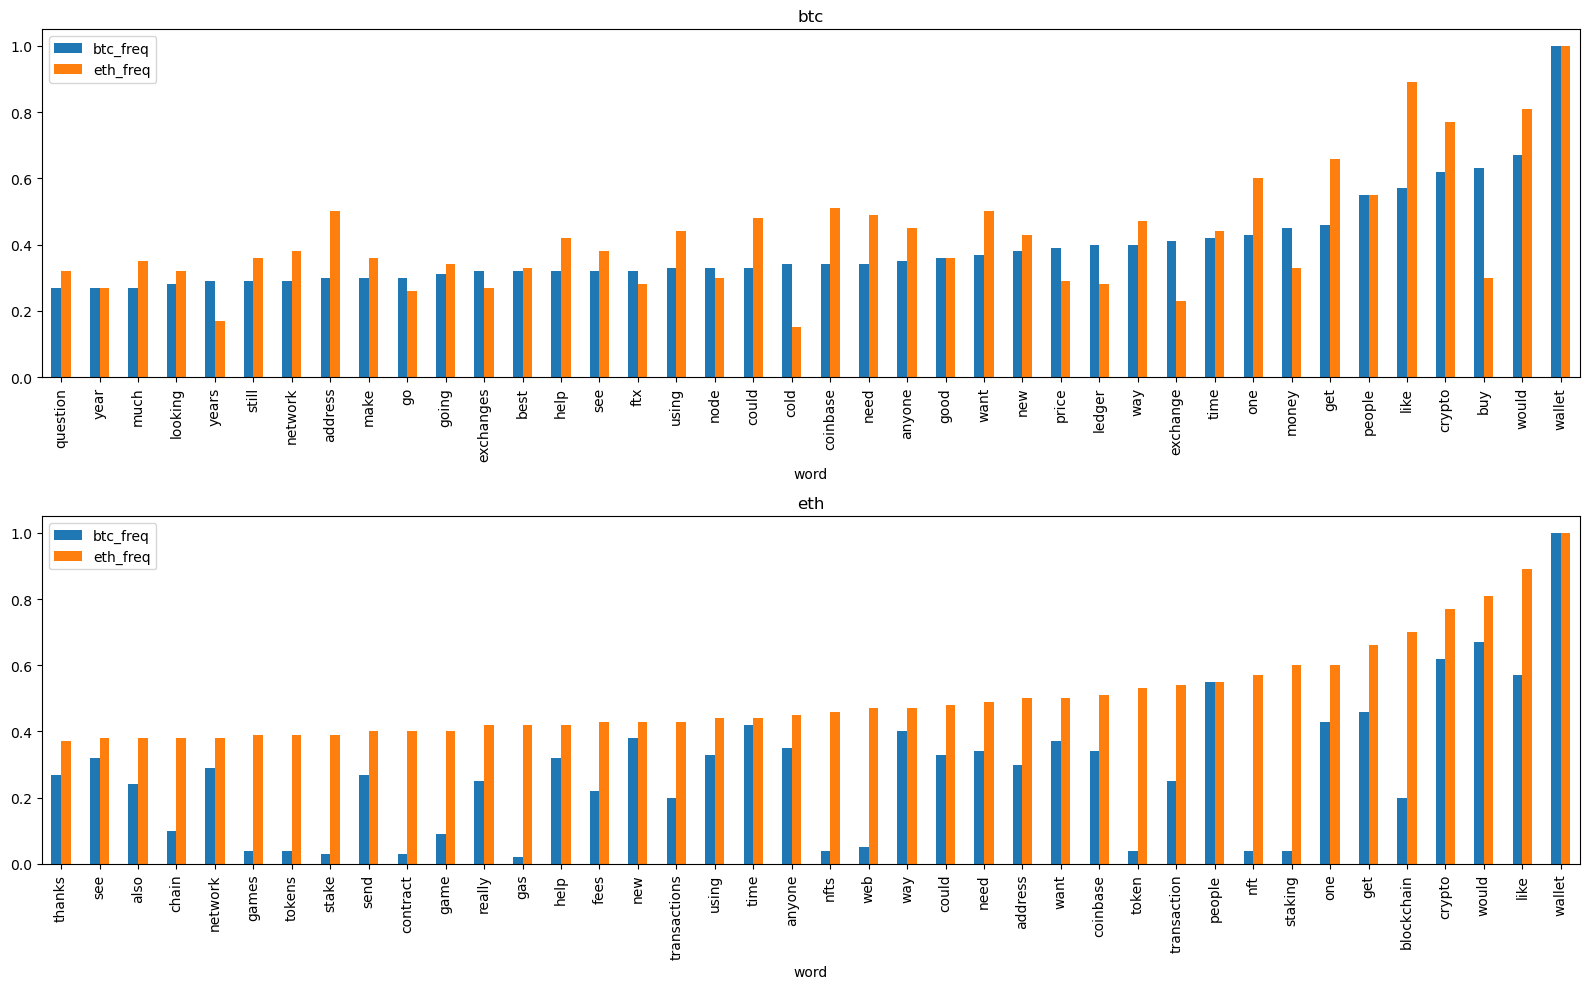

In [325]:
f, axes = plt.subplots(2,1, figsize=(16, 10))


scaled_df.sort_values(by = 'btc_freq', ascending = True).tail(40).plot.bar(ax = axes[0]);
scaled_df.sort_values(by = 'eth_freq', ascending = True).tail(40).plot.bar(ax = axes[1]);


axes[0].set_title('btc')
axes[1].set_title('eth')


plt.tight_layout();
plt.show();



In [326]:
scaled_df['average'] = ((scaled_df['btc_freq'] + scaled_df['eth_freq']) / 2)

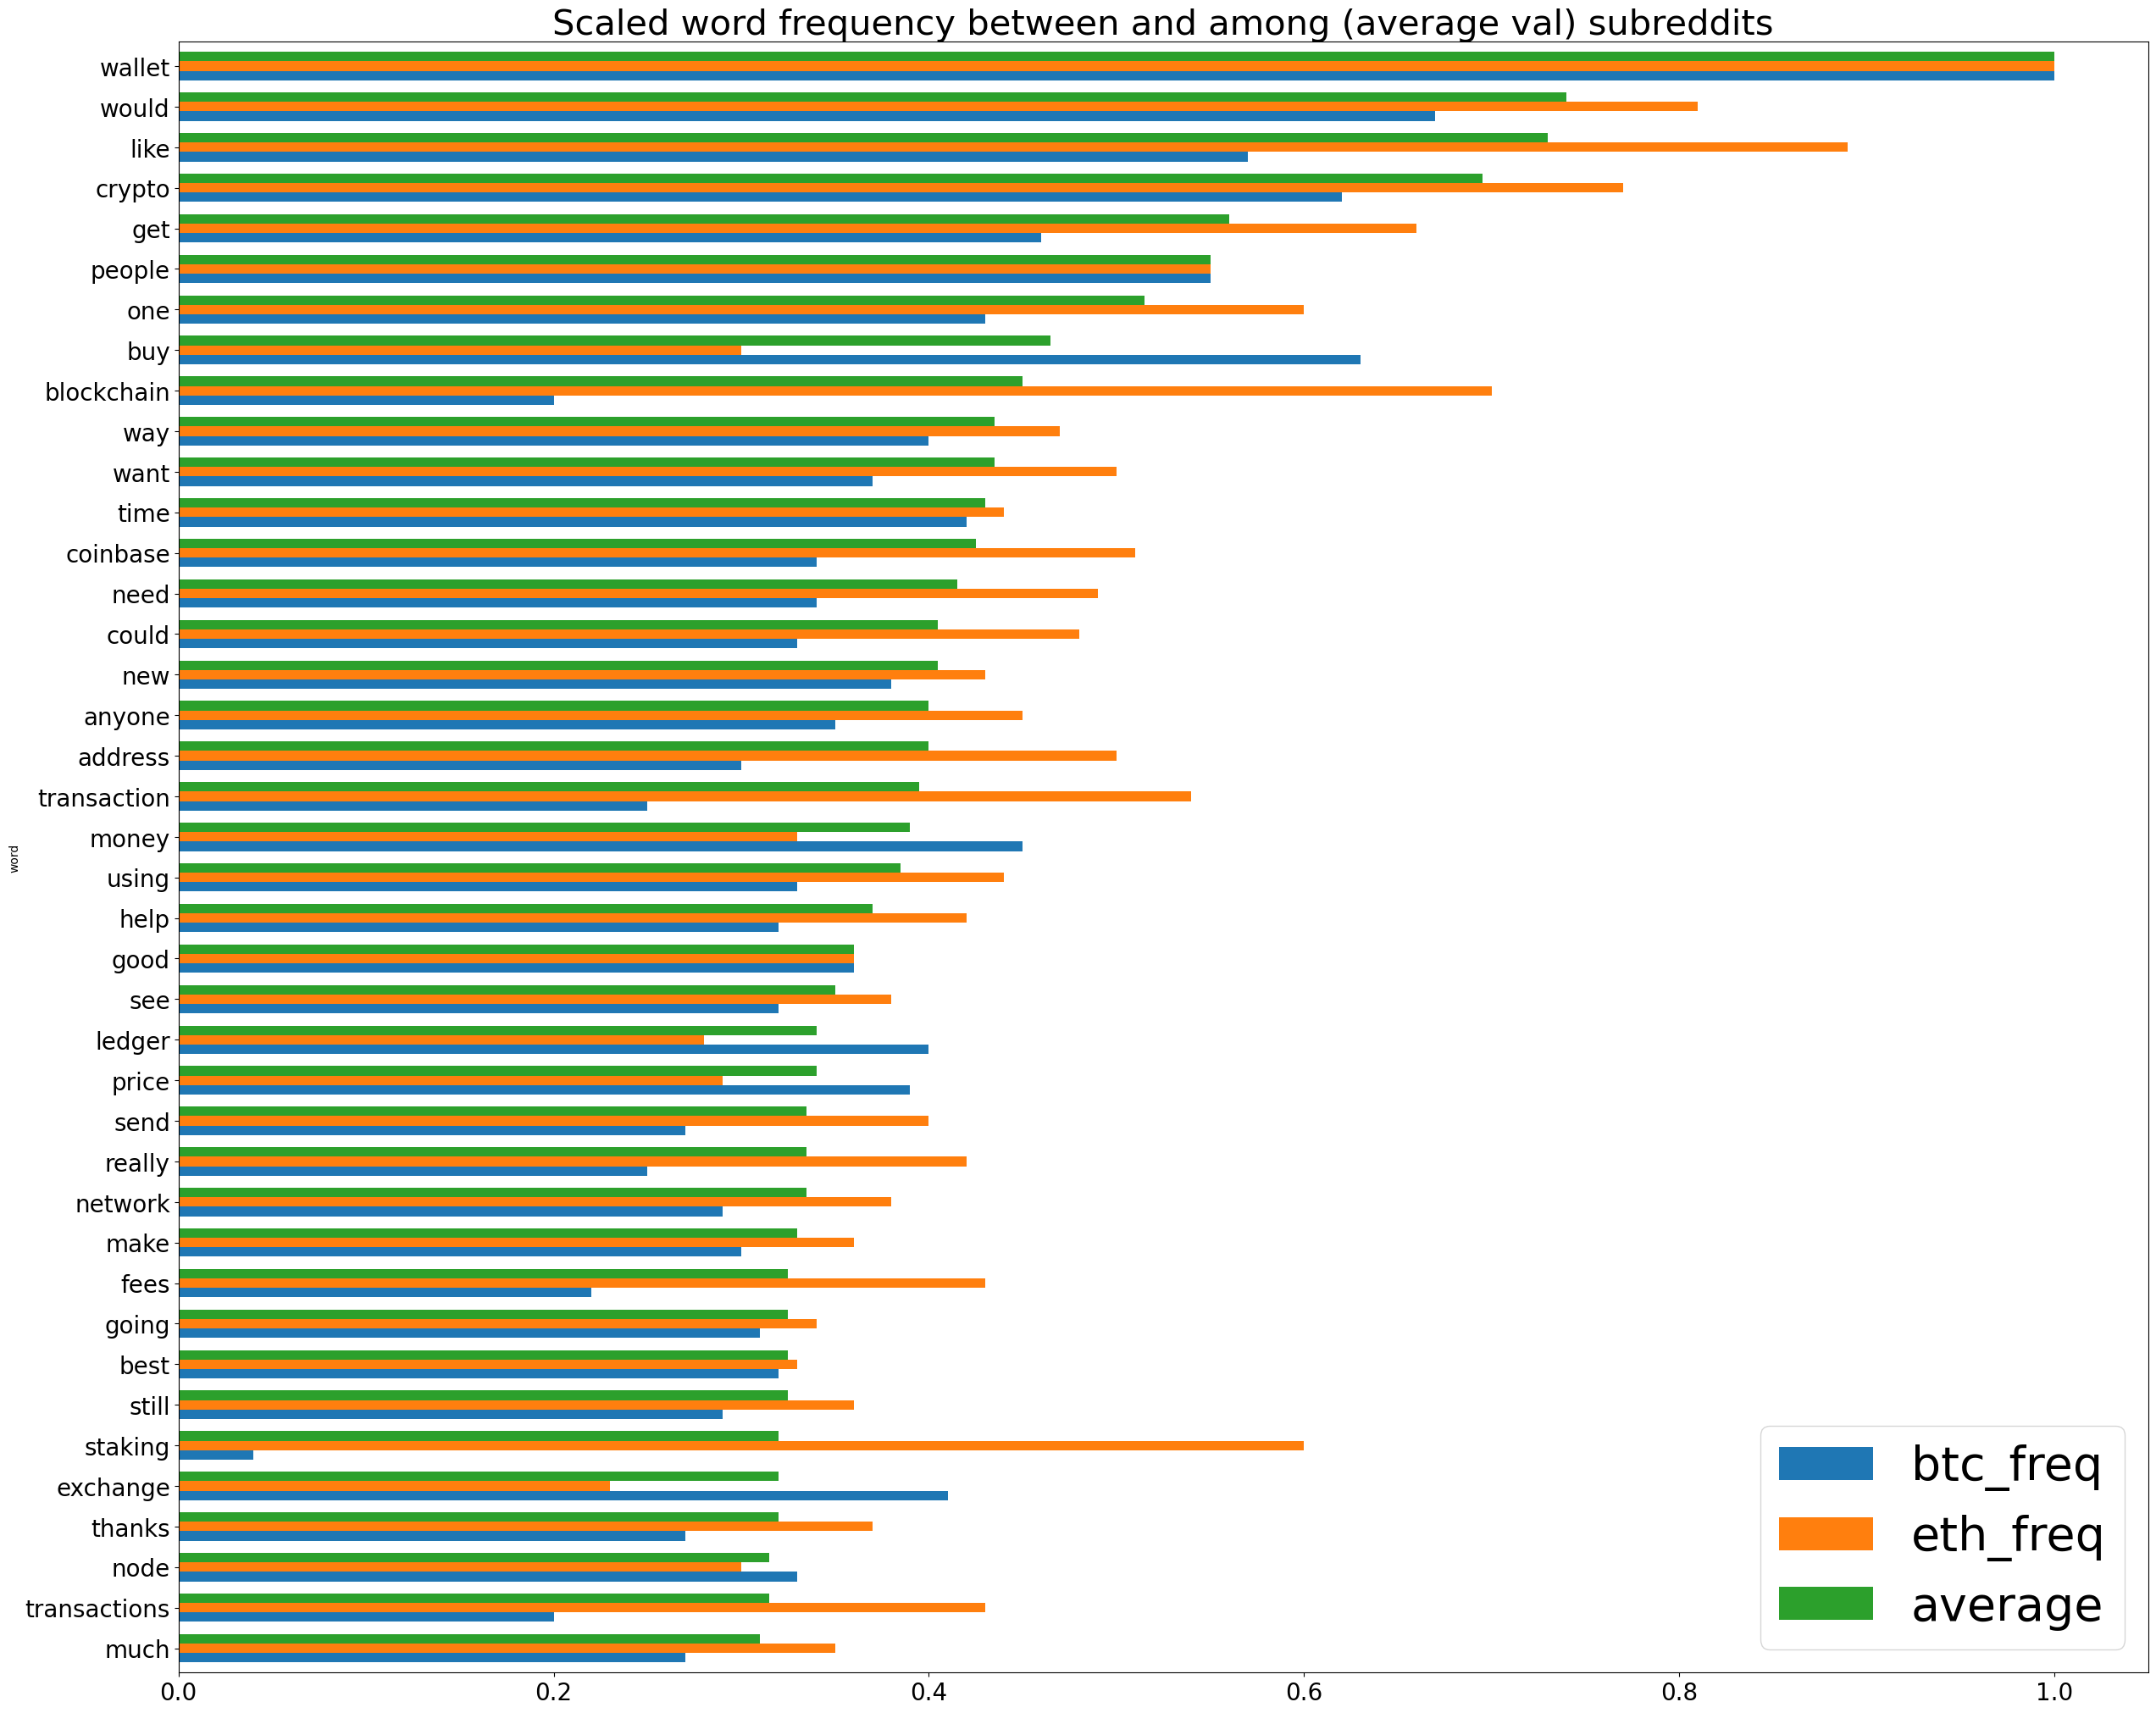

In [327]:
plot = scaled_df.sort_values(by = 'average', ascending = True).tail(40).plot.barh(figsize=(30, 25), fontsize = 20, width = .7);
plot.legend(loc=4, prop={'size': 40})
plt.title('Scaled word frequency between and among (average val) subreddits')
plot.title.set_size(30)

# Export

In [328]:
df_selftext.to_csv('../data/cleaned_selftext.csv', index = False)
df_notext.to_csv('../data/cleaned_notext.csv', index = False)
